Ex1: Code from scratch transposed convolution function

In [53]:
import torch

In [54]:
def trans_conv(X, K):
    """
    X: input matrix
    K: kernel matrix
    """
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

In [55]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
Y = trans_conv(X, K)

In [56]:
print(f"X:\n {X}")
print(f"K: \n {K}")
print(f"Output Y:\n {Y}")

X:
 tensor([[0., 1.],
        [2., 3.]])
K: 
 tensor([[0., 1.],
        [2., 3.]])
Output Y:
 tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])


Ex2: Given dataset cifar-10
- Let the noise for the dataset be sampled from normal distribution (mean = 0, variance = 0.1)
- Use the autoencoder structure to denoise the image back to its original state
- Visualize the original image, the image with added noise, and the image after denoise.


In [57]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn


data_dir = 'dataset'

train_dataset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size = 4

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [58]:
def add_noise(inputs):
     img = inputs+ torch.randn_like(inputs) * 0.2
     img = torch.clip(img,0.,1.)
     return img

Original Images


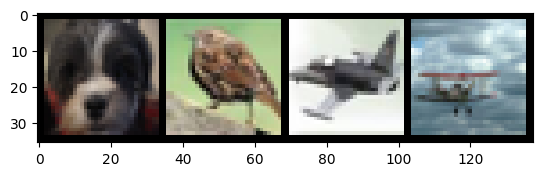

Noisy Images


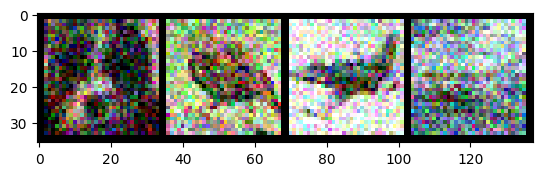

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, classes = next(iter(train_loader))
noisy_images = add_noise(images)

print("Original Images")
imshow(torchvision.utils.make_grid(images))
print("Noisy Images")
imshow(torchvision.utils.make_grid(noisy_images))


In [60]:
import torch.nn.functional as F
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        images, _ = data
        noisy_images = add_noise(images)
        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / (i+1):.4f}")

Epoch [1/5], Loss: 0.0062
Epoch [2/5], Loss: 0.0049
Epoch [3/5], Loss: 0.0048
Epoch [4/5], Loss: 0.0048
Epoch [5/5], Loss: 0.0047


Original Images


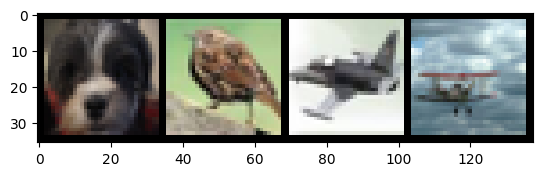

Noisy Images


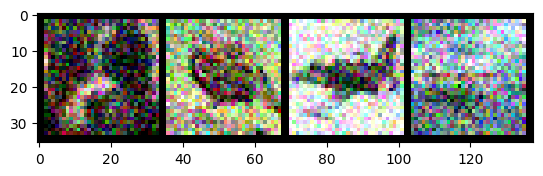

Denoised Images


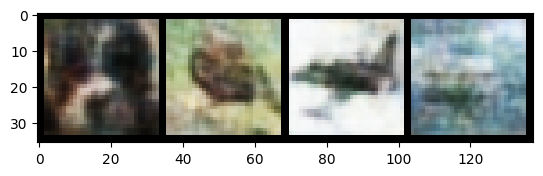

In [61]:
images, _ = next(iter(train_loader))
noisy_images = add_noise(images)
outputs = model(noisy_images).detach()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("Original Images")
imshow(torchvision.utils.make_grid(images))
print("Noisy Images")
imshow(torchvision.utils.make_grid(noisy_images))
print("Denoised Images")
imshow(torchvision.utils.make_grid(outputs))

Ex3: Given dataset cifar-10
- Reduce the data dimension to 2d form of any image using 2 methods: PCA and convolution AE.
- Visualize and compare the two methods

Original Images


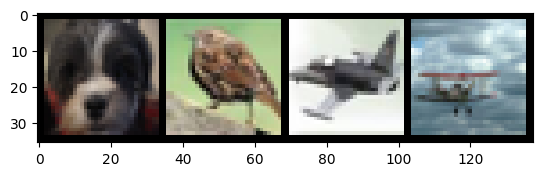

PCA


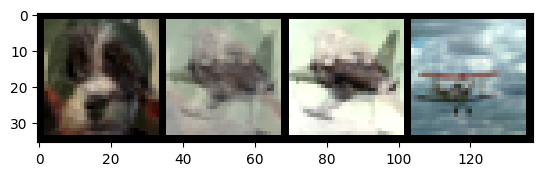

Autoencoder


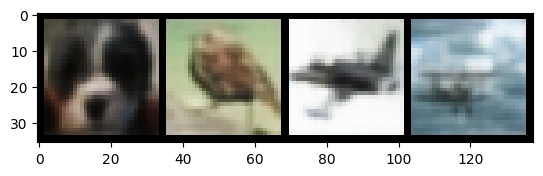

In [72]:
from sklearn.decomposition import PCA

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, _ = next(iter(train_loader))

print('Original Images')
imshow(torchvision.utils.make_grid(images))

images_flat = images.view(images.size(0), -1).numpy()

pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_flat)
images_pca_reconstructed = pca.inverse_transform(images_pca)
images_pca_reconstructed = torch.Tensor(images_pca_reconstructed).view_as(images)

print('PCA')
imshow(torchvision.utils.make_grid(images_pca_reconstructed))

model.eval()
with torch.no_grad():
    reconstructed = model(images).detach()

print('Autoencoder')
imshow(torchvision.utils.make_grid(reconstructed))